<table>
<tr>                                                                                   
     <th>
         <div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'>Transfert Style</div>
     </th>
 </tr>
</table>

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation du document</div></b>

In [1]:
import os
# import json
# @param ["tensorflow", "jax", "torch"]
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'  
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
# os.environ['TF_XLA_FLAGS']='--tf_xla_auto_jit=1,--tf_xla_always_defer_compilation=true'
# os.environ['XLA_FLAGS']='--xla_backend_optimization_level=0,--xla_gpu_autotune_level=4,--xla_gpu_disable_ptxas_optimizations=true,--xla_gpu_use_cudnn_batchnorm_level=2'
# os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL']='5'

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Import libriries </div></b>

In [2]:
import numpy as np, pandas as pd, seaborn as sns, warnings, os, sys, pickle, time
from matplotlib import pyplot as plt
from datetime import datetime as dt

import matplotlib.font_manager as fm
from matplotlib.lines import Line2D

warnings.filterwarnings(action="ignore")

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)

In [3]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.constraints import max_norm

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from sklearn.preprocessing import label_binarize
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc, accuracy_score, log_loss, hamming_loss, \
                            precision_score, recall_score, f1_score, fbeta_score, jaccard_score, \
                            precision_recall_curve, average_precision_score, balanced_accuracy_score, \
                            classification_report,roc_auc_score

tf.get_logger().setLevel('ERROR')# Suppress TensorFlow logging (2)

In [4]:
print("Tensorflow\t : %s\tCUDA %s\tGPU %s\tXLA %s\nKeras\t\t : %s\nPandas\t\t : %s\nNumPy\t\t : %s"%
      (tf.__version__, 
       tf.test.is_built_with_cuda(), 
       tf.test.is_built_with_gpu_support(), 
       tf.test.is_built_with_xla(), 
       tf.keras.__version__, 
       pd.__version__, 
       np.__version__))

Tensorflow	 : 2.17.0	CUDA True	GPU True	XLA True
Keras		 : 3.6.0
Pandas		 : 2.2.2
NumPy		 : 1.26.4


# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation des GPUs presents</div></b>

In [ ]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) >  0 :
    for i, gpu in enumerate(physical_devices):
        tf.config.experimental.set_memory_growth(physical_devices[i], True)

    strategy = tf.distribute.experimental.CentralStorageStrategy()
    print('Le système est initialisé avec {0:d} GPUs'.format(strategy.num_replicas_in_sync))

<table>
<tr>                                                                                   
     <th>
         <div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'><img src="https://raw.githubusercontent.com/rbizoi/DeepLearning/refs/heads/main/images/donnees/jason.jpg" width="1024"> </div>
     </th>
     <th>
<div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'>+</div>    
     </th>
     <th>
         <div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'><img src="https://raw.githubusercontent.com/rbizoi/DeepLearning/refs/heads/main/images/Vasiliy_Kandinskiy_transfer.jpg" width="1024"> </div>
     </th>
     <th>
<div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'>=</div>    
     </th>    
     <th>
         <div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'><img src="https://raw.githubusercontent.com/rbizoi/DeepLearning/refs/heads/main/images/jason.style_transfer.png" width="1024"> </div>
     </th>
 </tr>
</table>





In [6]:
nom_projet                = "11-1.Neural Style Transfer-Paul_Klee-Jason"
repertoireProjet          = os.getcwd()
repertoireImages          = repertoireProjet +'/'+nom_projet+ '/repertoire.images'
repertoireSauvegardes     = repertoireProjet +'/'+nom_projet+ '/repertoire.sauvegardes'

def controleExistenceRepertoire(directory, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(directory)
    if path_exists:
        if not os.path.isdir(directory):
            raise Exception("Trouvé le nom "+directory+" mais c'est un fichier, pas un répertoire")
            return False
        return True
    if create_if_needed:
        os.makedirs(directory)
        
controleExistenceRepertoire(repertoireImages)
controleExistenceRepertoire(repertoireSauvegardes)

True

In [7]:
!ls ../images/donnees/jason.jpg 
!ls ../images/Vasiliy_Kandinskiy_transfer.jpg

../images/donnees/jason.jpg
../images/Vasiliy_Kandinskiy_transfer.jpg


In [8]:
from keras.preprocessing.image import load_img, img_to_array

# This is the path to the image you want to transform.
base_image_path = '../images/donnees/jason.jpg'
# This is the path to the style image.
style_reference_image_path = '../images/Vasiliy_Kandinskiy_transfer.jpg'

result_prefix=f'{repertoireImages}/jason_gen'

# Dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_height = 400
img_width = int(width * img_height / height)

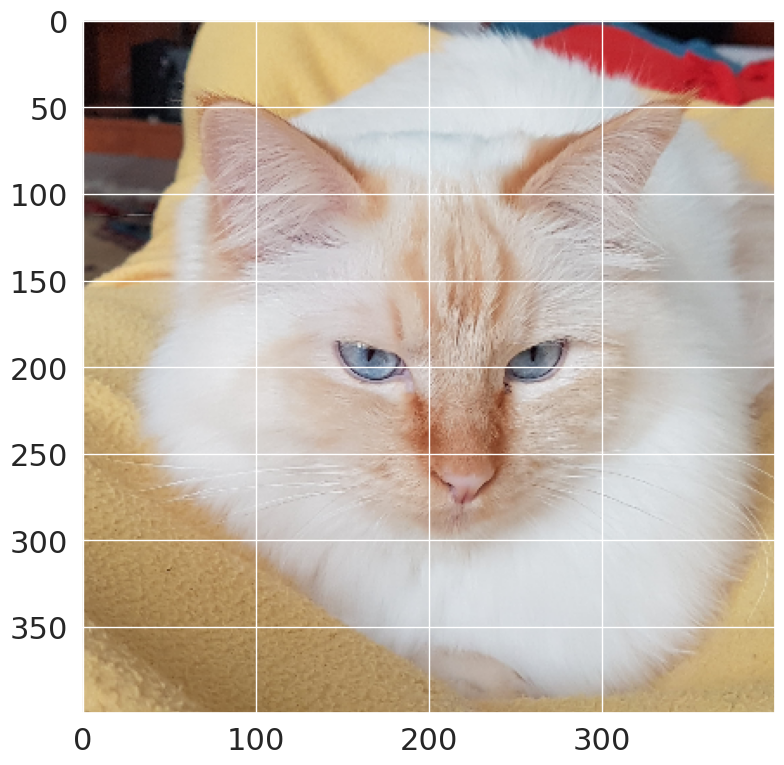

<Figure size 640x480 with 0 Axes>

In [9]:
# Style image
plt.figure(figsize=(12, 9))
plt.imshow(load_img(base_image_path, target_size=(img_height, img_width)))
plt.figure();

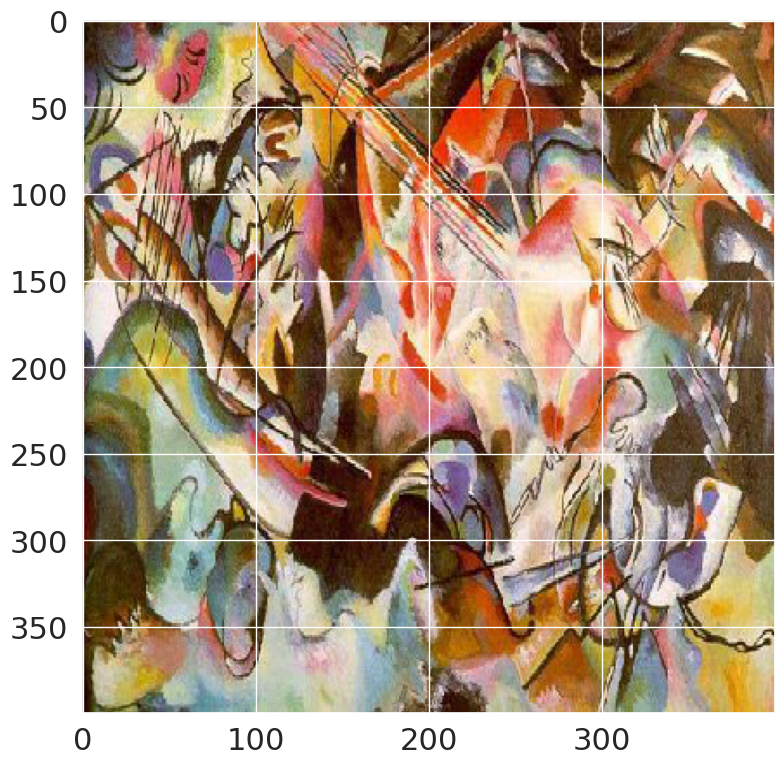

<Figure size 640x480 with 0 Axes>

In [10]:
# Style image
plt.figure(figsize=(12, 9))
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure();

In [11]:
# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)


In [12]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


In [13]:

# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))


"""
Next, let's create a feature extraction model that retrieves the intermediate activations
of VGG19 (as a dict, by name).
"""
from keras.applications import vgg19
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

"""
Finally, here's the code that computes the style transfer loss.
"""

# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


"""
## Add a tf.function decorator to loss & gradient computation

To compile it, and thus make it fast.
"""


@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads


"""
## The training loop

Repeatedly run vanilla gradient descent steps to minimize the loss, and save the
resulting image every 100 iterations.

We decay the learning rate by 0.96 every 100 steps.
"""

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 500 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

Iteration 500: loss=2667.06
Iteration 1000: loss=2404.36
Iteration 1500: loss=2294.33
Iteration 2000: loss=2232.67
Iteration 2500: loss=2193.53
Iteration 3000: loss=2166.61
Iteration 3500: loss=2147.32
Iteration 4000: loss=2132.98


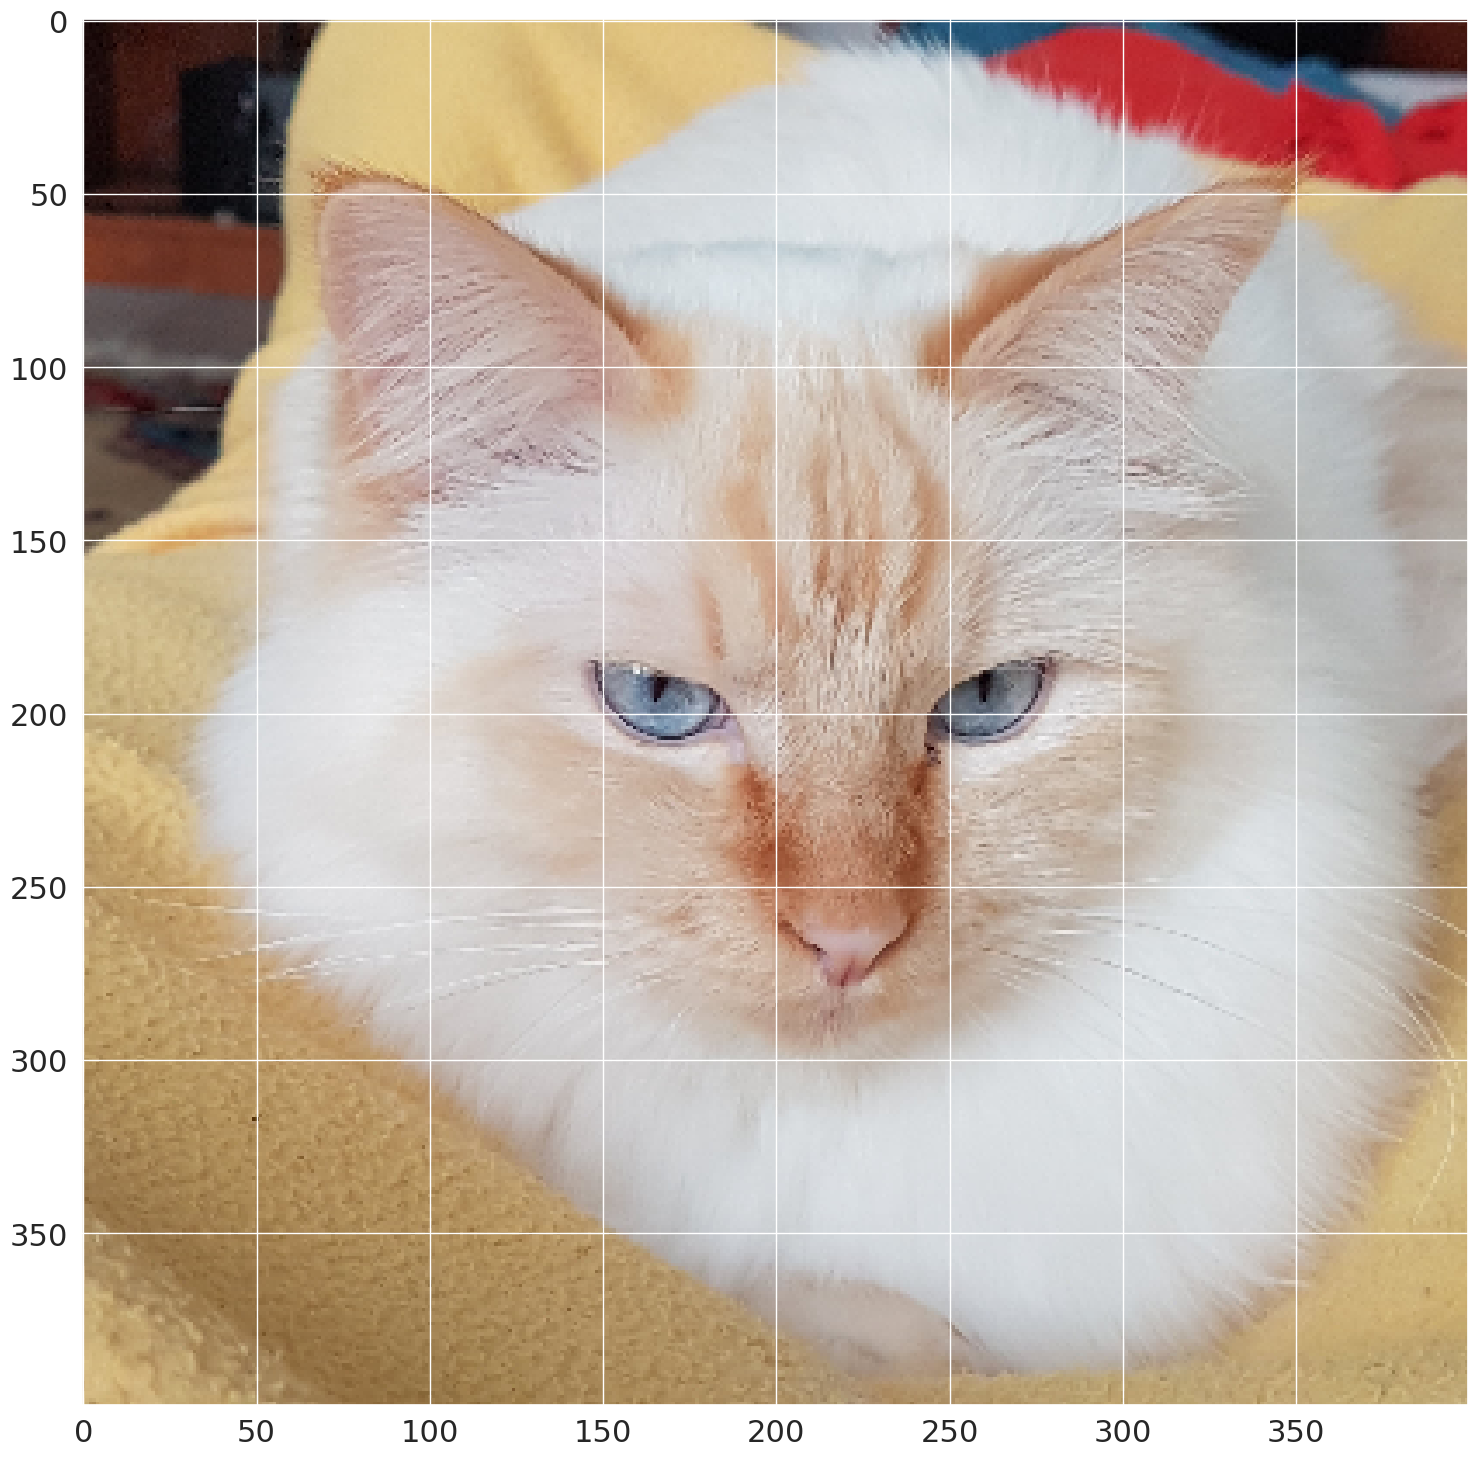

<Figure size 640x480 with 0 Axes>

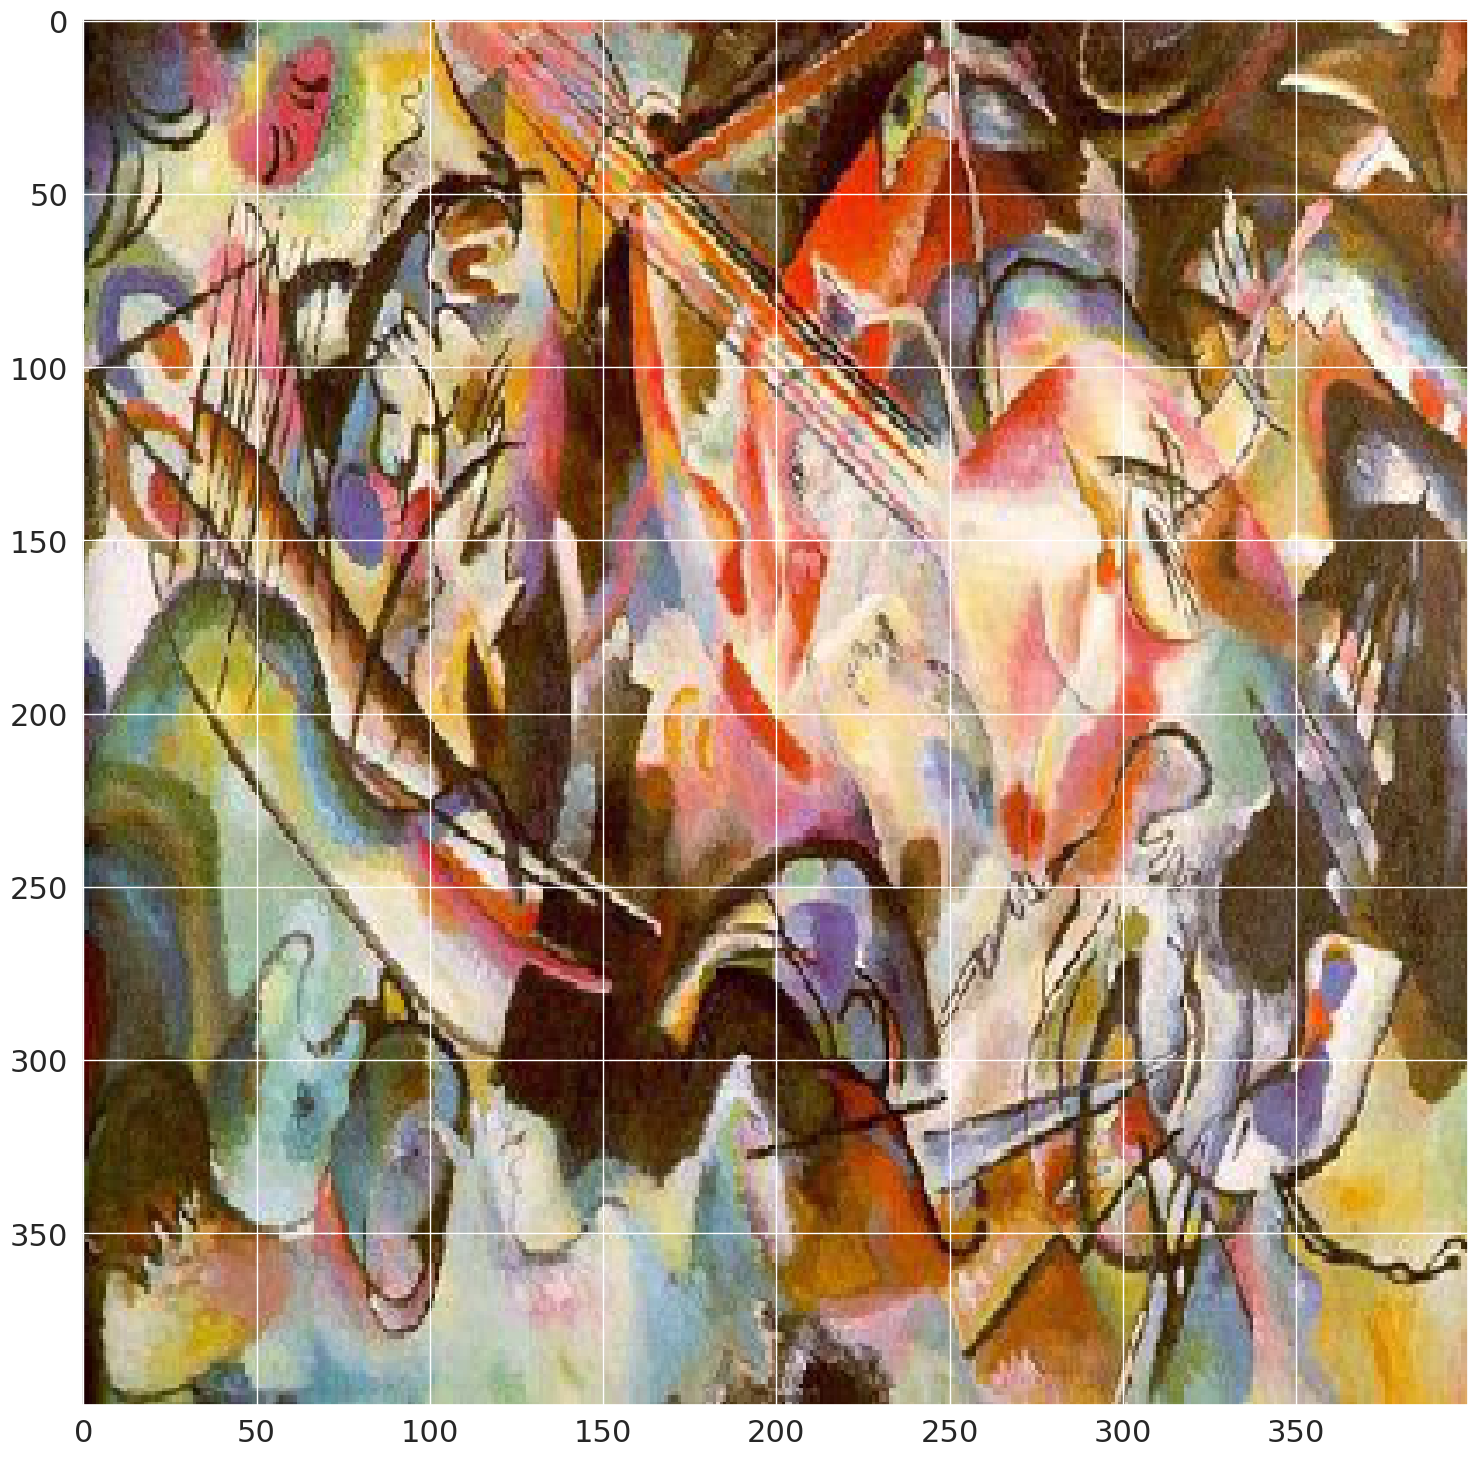

<Figure size 640x480 with 0 Axes>

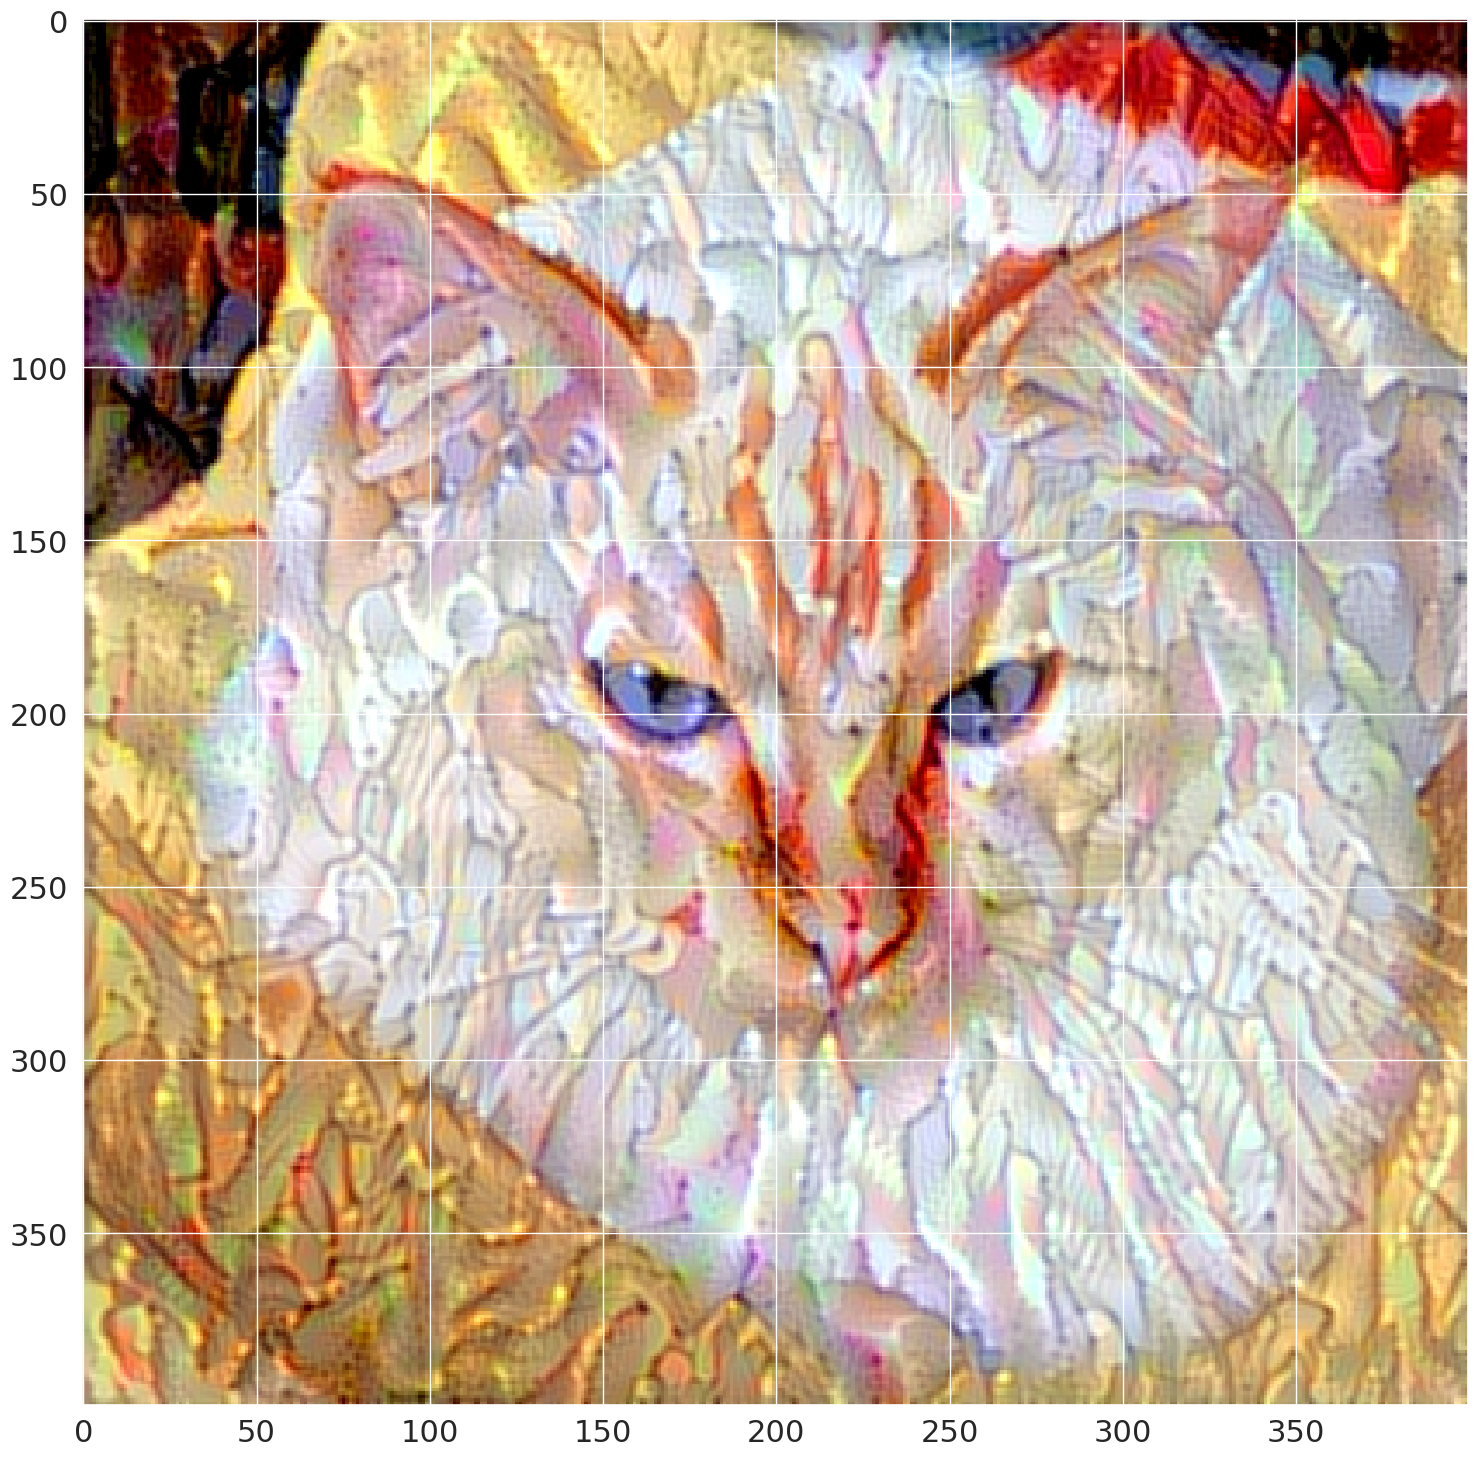

In [14]:
from matplotlib import pyplot as plt
from keras.preprocessing import image

# Content image
plt.figure(figsize=(24, 18))
plt.imshow(load_img(base_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.figure(figsize=(24, 18))
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.figure(figsize=(24, 18))
plt.imshow(load_img(result_prefix + "_at_iteration_4000.png", target_size=(img_height, img_width)))
plt.show()